# Denoising the BodyPix Overlay

Because the BodyPix demo scripts generate overalys with small salt-n-pepper noise on the RGB colormap, you must denoise the images before training the pix2pix models. We begin by importing some utilities for manipulating images and arrays, as well as the sklearn implementation for KMeans clustering.

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from matplotlib.pyplot import imshow

In [2]:
IMG_DIR = './masks/'
img_lst = os.listdir(IMG_DIR)

### We load an example overlay to visualize the person segmentation results

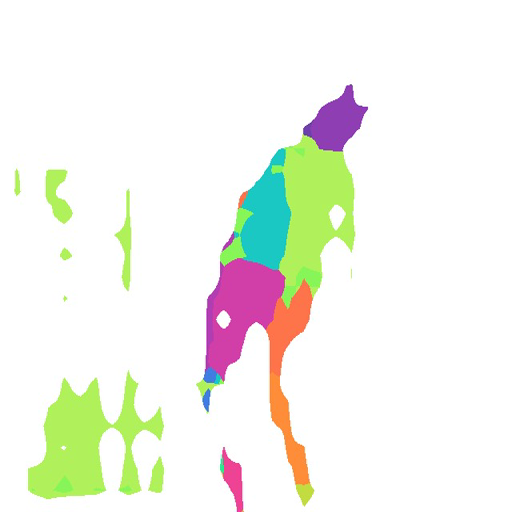

In [3]:
im = np.array(Image.open(IMG_DIR + img_lst[0]))
img = Image.fromarray(im)
img

### We inspect the mask to view the number of distinct pixel values

In [4]:
colors = []
for im in img_lst:
    im = np.array(Image.open(IMG_DIR + im))
    for val in np.unique(im.reshape(-1, im.shape[2]), axis=0):
        colors.append(val)
pixel_vals = np.unique(np.array(colors), axis=0)
print()
print('This mask contains {} unique colors'.format(pixel_vals.shape[0]))
print()
print('We only expect to find 25...')


This mask contains 1159228 unique colors

We only expect to find 25...


### Let's cluster pixel values 

In [5]:
kmeans = KMeans(n_clusters=25, init='k-means++', max_iter=300, n_init=10, random_state=0)

### Use fit_predict method to transform the images

Originals had over 1 million colors, the transformed images will have no more than 25

In [6]:
%%time
pred_y = kmeans.fit_predict(pixel_vals)

CPU times: user 17min 20s, sys: 13min 27s, total: 30min 48s
Wall time: 13min 26s


### Using a Colormap to Render Training Masks

In [7]:
# grabbing a test image
imm = im.reshape(-1, im.shape[2])

In [8]:
color_map = dict(zip(tuple((tuple(tup) for tup in pixel_vals)), pred_y))

Next, use the color map to replace each original pixel value with: [cluster_id, cluster_id, cluster_id]

In [9]:
for idx, pixel in enumerate(imm):
    new_color = [color_map[tuple(pixel)]] * 3
    imm[idx] = new_color

### Visualize an Example Mask
Let's take a look and make sure the mask was generated correctly!

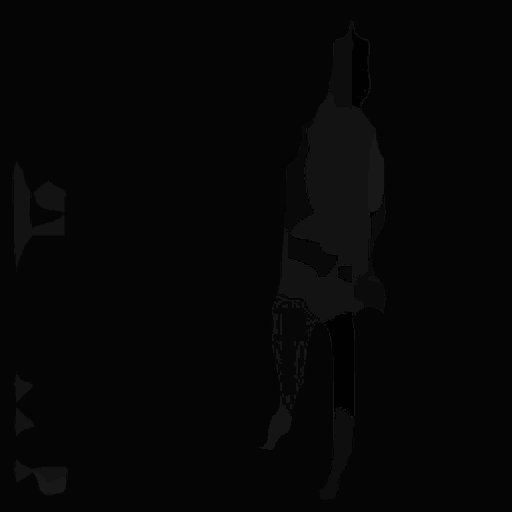

In [10]:
Image.fromarray(imm.reshape(512, 512, 3))

### Train on image corpus to transform BodyPix Overlays into Segmentation Masks

We've wrapped the experiments above into a function. This function will take a list of images like ['00001.png', '00002.png', ...] and the directory where the images are stored. It will return two lists, the first one containing the converted masks as PIL images and the second containing the names of the files it failed to convert. If the save flag is set to True, the converted masks will be written to file, overwritting the old masks.

In [12]:
def generate_mask(img_lst, img_dir, save=False):
    """
    Generate mask with new mapping
    Input is a list of image file names and directory where images are stored
    Set the save variable to True to overwrite masks with new masks
    Returns a list of successful converted masks and a list of failed conversions
    """
    colors = []
    for im in img_lst:
        im = np.array(Image.open(img_dir + im))
        for val in np.unique(im.reshape(-1, im.shape[2]), axis=0):
            colors.append(val)
    # get unique colors from list of images
    pixel_vals = np.unique(np.array(colors), axis=0)
    
    # predict mapping to 25 colors
    pred_y = kmeans.fit_predict(pixel_vals)
    
    #generate color map
    color_map = dict(zip(tuple((tuple(tup) for tup in pixel_vals)), pred_y))
    
    # transform overlays
    generated_imgs = []
    failed_imgs = []
    for im in img_lst:
        try:
            im = np.array(Image.open(img_dir + im))
            imm = im.reshape(-1, im.shape[2])
            for idx, pixel in enumerate(imm):
                new_color = [color_map[tuple(pixel)]] * 3
                imm[idx] = new_color
            imm = imm.reshape(512, 512, 3)
            save_img = Image.fromarray(imm)
            generated_imgs.append(save_img)
            if save:
                save_img.save(img_dir + im, "png")
        except:
            failed_imgs.append(im)
    return generated_imgs, failed_imgs


In [13]:
success_imgs, failed_imgs = generate_mask(img_lst[:3], IMG_DIR)

Now let's look at an example mask after conversion:

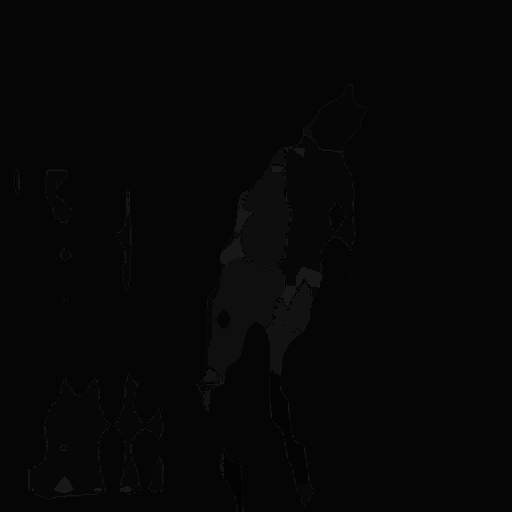

In [14]:
success_imgs[0]